In [2]:
from functools import partial
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import cv2

#let's hide the warnings of feature depreciation and other 
warnings.filterwarnings('ignore')

# 1. LOADING & VISUALIZING DATA 

The process of copying and loading data or data sets from a source file, folder, or program to a database or other application is known as data loading. Copying digital data from a source and pasting or loading the data into a data storage or processing facility is the most common method.

The graphical depiction of information and data is known as data visualization. Data visualization tools make it easy to examine and comprehend trends, outliers, and patterns in data by applying visual elements like charts, graphs, and maps.

In [3]:
#First we are going to access the file paths and store the location of the input data
images_dir = 'dataset/in'   #path where satellite images are stored
masks_dir = 'dataset/out'   #path where masked images of watersheds are stored

dirname, _, filenames = next(os.walk(images_dir))


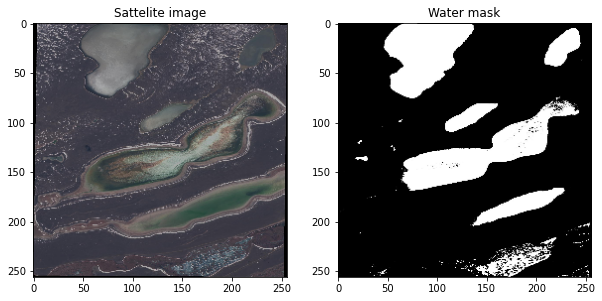

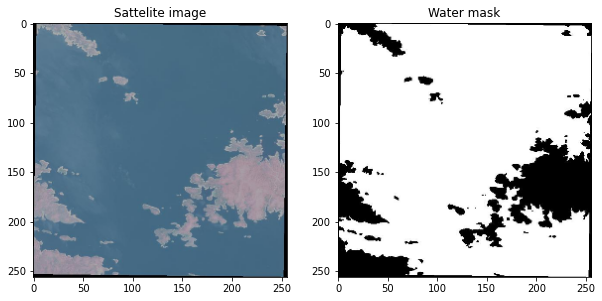

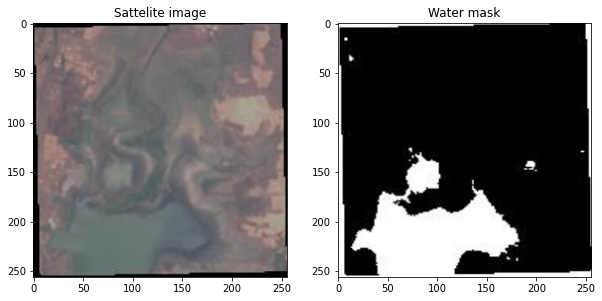

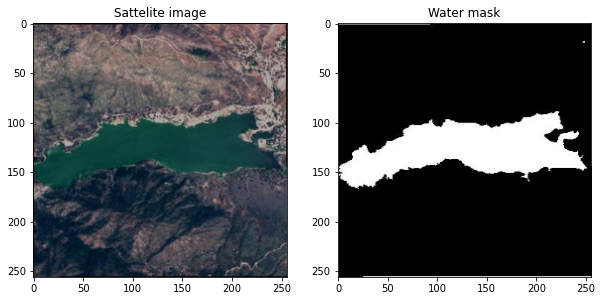

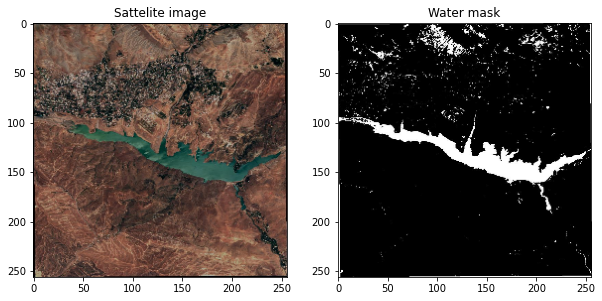

In [4]:
#number of dataset you want to visualize
n=5

for i in range(n) :
  figure,ax = plt.subplots(1,2,figsize=(10,10))
  
  #Loading satellite image   
  x=cv2.imread('dataset/in/'+filenames[i])
  x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
  x = cv2.resize(x,(256,256))
  
  #Loading masked dataset
  y=cv2.imread('dataset/out/'+filenames[i])
  y = cv2.cvtColor(y,cv2.COLOR_BGR2RGB)
  y = cv2.resize(y,(256,256))
  
  #satellite and masked image visualization in Grid
  ax[0].imshow(x)
  ax[1].imshow(y, cmap='gray')
 
  #providing the title of Grid Images
  ax[0].set_title("Sattelite image")
  ax[1].set_title("Water mask")

# 2. Checking Quality of Dataset

The reliability of a dataset is measured by its data quality. The user's capacity to make correct decisions on the subject of their study will be influenced by the data's quality.

In [5]:
from matplotlib import image
mean_labels = []
heights = []
widths = []

for f in filenames:
    img = image.imread('dataset/out/'+f)
    mean_labels.append(np.mean(np.array(img)))
    widths.append(img.shape[0])
    heights.append(img.shape[1])

Text(0.5, 0, 'Image Height')

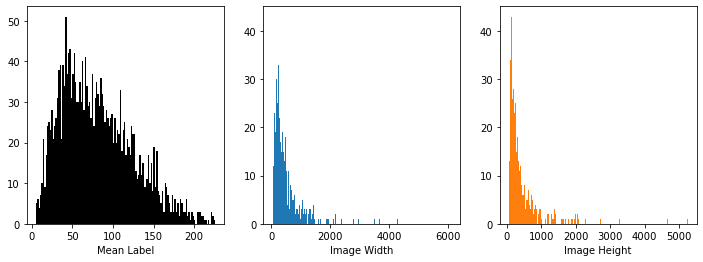

In [6]:
plt.figure(figsize=(12,4))

plt.subplot(131)
plt.hist(mean_labels,bins=128,color="k")
plt.xlabel("Mean Label")

plt.subplot(132)
plt.hist(widths,bins=1024,color="C0")
plt.xlabel("Image Width")

plt.subplot(133)
plt.hist(heights,bins=1024,color="C1")
plt.xlabel("Image Height")

It seems that there no completely black or completely white images data in masked dataset, hence we aren't required to perform filterning. These cases seem to be labeled right in many cases. Hence we are good with the dataset.

# 3. Data Augmentation

The quantity and diversity of training data determine the success of most machine learning models, and deep learning models in particular. However, one of the most prevalent problems in applying machine learning in the organization is a lack of data. This is due to the fact that gathering such information can be costly and time-consuming in many circumstances.

In [7]:
len(filenames)

2269

Here in our case, we have just 2269 masked and 2269 satellite image dataset. As we are using Deep learing algorithm to train our model, it is insufficient. Hence we are using data augmentation technique to increase the amount of dataset for our project. Let's start with the simple introduction:

Data augmentation is a set of techniques for producing additional data points from current data in order to artificially increase the amount of data available. Making modest adjustments to data or utilizing deep learning models to produce additional data points are examples of this.


## Why is it important now?

Machine learning applications, particularly in the deep learning domain, are rapidly diversifying and expanding. Techniques for data augmentation could be useful in combating the issues that the artificial intelligence sector faces.

By creating fresh and varied instances to train datasets, data augmentation can help improve the performance and results of machine learning models. A machine learning model performs better and is more accurate when the dataset is rich and sufficient.

## How it is done ?

For data augmentation, making simple alterations on visual data is popular. In addition, generative adversarial networks (GANs) are used to create new synthetic data. Classic image processing activities for data augmentation are:

1. padding
2. random rotating
3. re-scaling,
4. vertical and horizontal flipping
5. translation ( image is moved along X, Y direction)
6. cropping
7. zooming
8. darkening & brightening/color modification
9. grayscaling
10. changing contrast
11. adding noise
12.random erasing

## How is it done in our Project ?

For our project, we are using rotation techniques to increase the size of dataset. Using this method, dataset can be increase from 2x to 4x. We are using rotation angles of 90, 180, 270. Hence the dataset will be increased by 4 times.

In [8]:
# import the Python Image
from PIL import Image

for f in filenames:
    # rotating & saving images
    s_image=Image.open(images_dir+'/'+f)
    (s_image.rotate(90)).save('dataset/in/'+'90'+f)
    (s_image.rotate(180)).save('dataset/in/'+'180'+f)
    (s_image.rotate(270)).save('dataset/in/'+'270'+f)
    
    #rotating masked images 
    m_image=Image.open(masks_dir+f)
    (s_image.rotate(90)).save('dataset/out/'+'90'+f)
    (s_image.rotate(180)).save('dataset/out/'+'180'+f)
    (s_image.rotate(270)).save('dataset/out/'+'270'+f)  
    

In [10]:
dirname, _, filenames = next(os.walk(images_dir))
len(filenames)*2

18152


Finally we have about 18.2K dataset. 

# 4. Creating Model

In [11]:
def get_unet(hidden_activation='relu', initializer='he_normal', output_activation='sigmoid'):
  PartialConv = partial(keras.layers.Conv2D,activation=hidden_activation,kernel_initializer=initializer,padding='same')
  # Encoder
  model_input = keras.layers.Input(shape=(None, None, 3))
  enc_cov_1 = PartialConv(32, 3)(model_input)
  enc_cov_1 = PartialConv(32, 3)(enc_cov_1)
  enc_pool_1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_1)
  enc_cov_2 = PartialConv(64, 3)(enc_pool_1)
  enc_cov_2 = PartialConv(64, 3)(enc_cov_2)
  enc_pool_2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_2)
    
  enc_cov_3 = PartialConv(128, 3)(enc_pool_2)
  enc_cov_3 = PartialConv(128, 3)(enc_cov_3)
  enc_pool_3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_3)
    
  # Center
  center_cov = PartialConv(256, 3)(enc_pool_3)
  center_cov = PartialConv(256, 3)(center_cov)
    
  # Decoder
  upsampling1 = keras.layers.UpSampling2D(size=(2, 2))(center_cov)
  dec_up_conv_1 = PartialConv(128, 2)(upsampling1)
  dec_merged_1 = tf.keras.layers.Concatenate(axis=3)([enc_cov_3, dec_up_conv_1])
  dec_conv_1 = PartialConv(128, 3)(dec_merged_1)
  dec_conv_1 = PartialConv(128, 3)(dec_conv_1)
    
  upsampling2 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_1)
  dec_up_conv_2 = PartialConv(64, 2)(upsampling2)
  dec_merged_2 = tf.keras.layers.Concatenate(axis=3)([enc_cov_2, dec_up_conv_2])
  dec_conv_2 = PartialConv(64, 3)(dec_merged_2)
  dec_conv_2 = PartialConv(64, 3)(dec_conv_2)
    
  upsampling3 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_2)
  dec_up_conv_3 = PartialConv(32, 2)(upsampling3)
  dec_merged_3 = tf.keras.layers.Concatenate(axis=3)([enc_cov_1, dec_up_conv_3])
  dec_conv_3 = PartialConv(32, 3)(dec_merged_3)
  dec_conv_3 =  PartialConv(32, 3)(dec_conv_3)
    
  output = keras.layers.Conv2D(1, 1, activation=output_activation)(dec_conv_3)
  return tf.keras.Model(inputs=model_input, outputs=output)

In [15]:
model=get_unet()
optimizer = tf.keras.optimizers.Nadam()
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

warnings.filterwarnings('ignore')

In [16]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   896         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, None, None,   9248        ['conv2d_36[0][0]']              
                                32)                                                         

                                                                                                  
 conv2d_53 (Conv2D)             (None, None, None,   33          ['conv2d_52[0][0]']              
                                1)                                                                
                                                                                                  
Total params: 1,925,601
Trainable params: 1,925,601
Non-trainable params: 0
__________________________________________________________________________________________________


In [17]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint ,TensorBoard

EarlyStop = EarlyStopping(patience = 10, restore_best_weights = True)
Reduce_LR = ReduceLROnPlateau(monitor = 'val_accuracy', verbose = 2, factor = 0.5, min_lr = 0.00001)
model_check = ModelCheckpoint('model.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True)
tensorboard = TensorBoard(log_dir = 'logs')
callback = [EarlyStop , Reduce_LR, model_check, tensorboard]

In [18]:
training_history = model.fit(X_train, Y_train, validation_split = 0.1 , epochs = 100, batch_size = 32, callbacks = callback, verbose = 1)

print('training complete !!')

training complete !!


In [19]:
model.save("trained_model.h5")

In [56]:
loss,accuracy = UNet.evaluate(X_test, Y_test)
print(accuracy)

0.7839


# 5. Testing Model

Text(0.5, 1.0, 'Predicted mask')

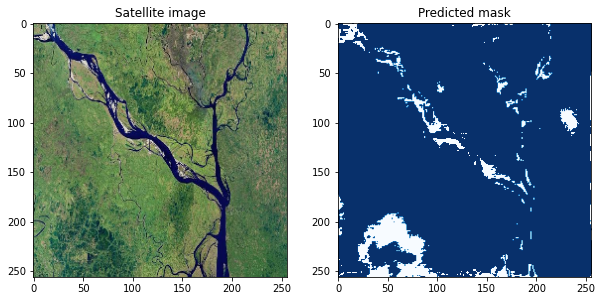

In [61]:
# Load your trained model
model = load_model('trained_model.h5')

water_test = cv2.imread('dataset/test/12.jpg')   #change the path to test images 
water_test_to_RGB = cv2.cvtColor(water_test,cv2.COLOR_BGR2RGB)
water_test_resized = cv2.resize(water_test_to_RGB,(256,256))

water_test_for_prediction = np.expand_dims(water_test_resized, axis=0)
y_pred = model.predict(water_test_for_prediction)

predicted_mask = np.squeeze(y_pred)
predicted_mask_binary = (predicted_mask > 0.6).astype(np.uint8)

figure,ax = plt.subplots(1,2,figsize=(10,10))    
ax[0].imshow(water_test_resized)
ax[1].imshow(predicted_mask_binary, cmap='Blues')
ax[0].set_title("Satellite image")
ax[1].set_title("Predicted mask")